Liberer completement la memoire GPU avant de commencer


In [1]:
import torch
import gc

# Vider le cache CUDA
torch.cuda.empty_cache()

# Forcer le garbage collector
gc.collect()

# Verifier l'etat du GPU
if torch.cuda.is_available():
    print(f"GPU detecte: {torch.cuda.get_device_name(0)}")
    print(f"Memoire GPU totale: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"Memoire GPU allouee: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"Memoire GPU reservee: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
    print("GPU pret pour l'entrainement")
else:
    print("ATTENTION: Aucun GPU detecte, utilisation du CPU")

GPU detecte: NVIDIA GeForce RTX 3060 Laptop GPU
Memoire GPU totale: 6.00 GB
Memoire GPU allouee: 0.00 GB
Memoire GPU reservee: 0.00 GB
GPU pret pour l'entrainement


In [4]:
!pip install seaborn

import

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
import json
from pathlib import Path

warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tqdm import tqdm

# Configurer le device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilise: {device}")

# Fixer les seeds pour reproductibilite
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Imports charges et seeds fixes")

Device utilise: cuda
Imports charges et seeds fixes


Configuration

In [3]:

CONFIG = {
    # Architecture
    'MODEL_NAME': 'tf_efficientnet_b4',  # EfficientNet-B4 optimal
    'NUM_CLASSES': 9,  # 8 pathologies + 1 healthy
    
    # Donnees
    'IMAGE_SIZE': 380,  # Taille optimale pour EfficientNet-B4
    'BATCH_SIZE': 16,   # Optimal pour 6GB GPU avec cette taille d'image
    'NUM_WORKERS': 0,   # Chargement parallele
    
    # Entrainement
    'NUM_EPOCHS': 20,
    'LEARNING_RATE': 1e-4,  # LR initial optimise
    'WEIGHT_DECAY': 1e-5,   # Regularisation L2
    'LABEL_SMOOTHING': 0.1,  # Ameliore la generalisation
    
    # Early stopping et patience
    'EARLY_STOP_PATIENCE': 7,
    'SCHEDULER_PATIENCE': 3,
    'SCHEDULER_FACTOR': 0.5,
    
    # Chemins
    'DATA_DIR': './allergy/allergy',  # Dossier contenant les 11 classes
    'SAVE_DIR': './models',
    
    # Autre
    'SEED': 42,
    'MIXED_PRECISION': True  # Active le mixed precision pour economiser memoire
}

# Creer le dossier de sauvegarde
os.makedirs(CONFIG['SAVE_DIR'], exist_ok=True)

print("Configuration chargee:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration chargee:
  MODEL_NAME: tf_efficientnet_b4
  NUM_CLASSES: 9
  IMAGE_SIZE: 380
  BATCH_SIZE: 16
  NUM_WORKERS: 0
  NUM_EPOCHS: 20
  LEARNING_RATE: 0.0001
  WEIGHT_DECAY: 1e-05
  LABEL_SMOOTHING: 0.1
  EARLY_STOP_PATIENCE: 7
  SCHEDULER_PATIENCE: 3
  SCHEDULER_FACTOR: 0.5
  DATA_DIR: ./allergy/allergy
  SAVE_DIR: ./models
  SEED: 42
  MIXED_PRECISION: True


 Charger les donnees depuis le dossier allergy


Classe 0: Atopic Dermatitis - 7645 images
Classe 1: Dermatophytie - 6634 images
Classe 2: Eczema Photos - 6715 images
Classe 3: Gale - 7717 images
Classe 4: Heathy - 7758 images
Classe 5: Impétigo - 7894 images
Classe 6: Maladie cutanée auto-immune - 6502 images
Classe 7: Urticaria Hives - 7993 images
Classe 8: drug reactions - 7750 images

STATISTIQUES DU DATASET
Total d'images: 66608
Nombre de classes: 9

Classes détectées: ['Atopic Dermatitis', 'Dermatophytie', 'Eczema Photos', 'Gale', 'Heathy', 'Impétigo', 'Maladie cutanée auto-immune', 'Urticaria Hives', 'drug reactions']

Distribution par classe:
class_name
Atopic Dermatitis              7645
Dermatophytie                  6634
Eczema Photos                  6715
Gale                           7717
Heathy                         7758
Impétigo                       7894
Maladie cutanée auto-immune    6502
Urticaria Hives                7993
drug reactions                 7750
Name: count, dtype: int64


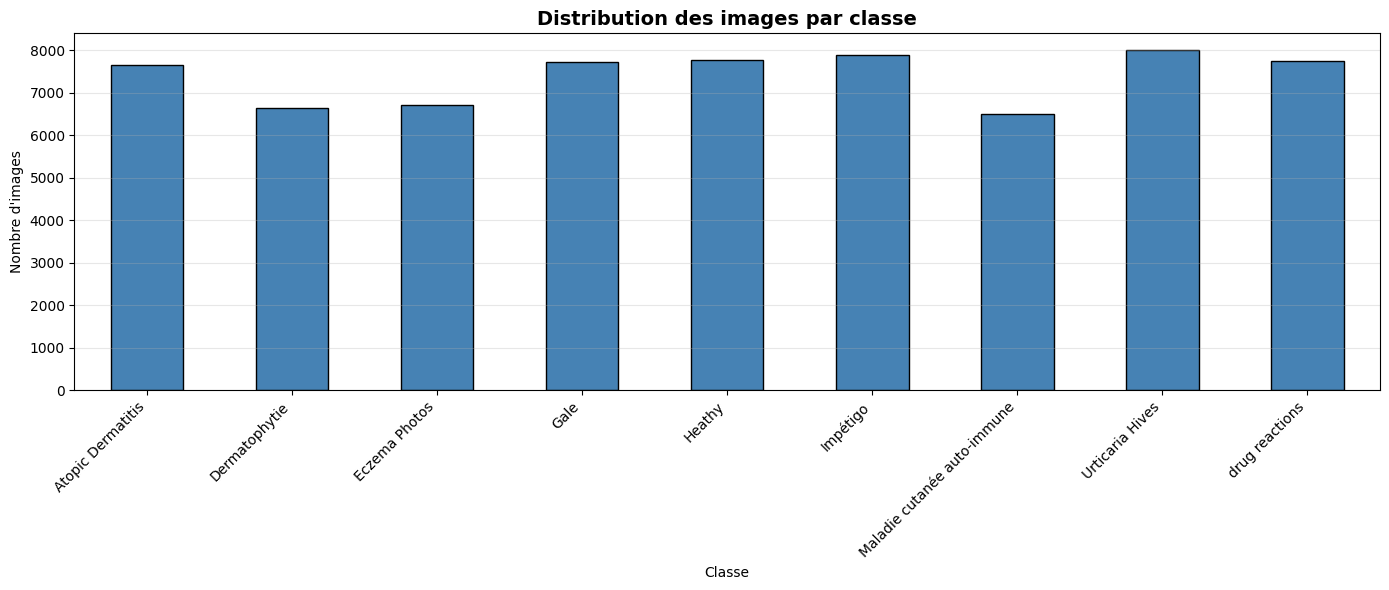


Graphique sauvegardé dans ./models/class_distribution.png


In [4]:
data_list = []
class_names = []

# Parcourir tous les dossiers de classes
for class_name in sorted(os.listdir(CONFIG['DATA_DIR'])):
    class_path = os.path.join(CONFIG['DATA_DIR'], class_name)
    
    # Vérifier que c'est un dossier
    if not os.path.isdir(class_path):
        continue
    
    class_idx = len(class_names)
    class_names.append(class_name)
    
    # Parcourir toutes les images de cette classe
    image_count = 0
    for img_name in os.listdir(class_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            img_path = os.path.join(class_path, img_name)
            data_list.append({
                'image_path': img_path,
                'label': class_idx,
                'class_name': class_name
            })
            image_count += 1
    
    print(f"Classe {class_idx}: {class_name} - {image_count} images")

# Créer le DataFrame
import pandas as pd
df = pd.DataFrame(data_list)

print(f"\n{'='*60}")
print(f"STATISTIQUES DU DATASET")
print(f"{'='*60}")
print(f"Total d'images: {len(df)}")
print(f"Nombre de classes: {len(class_names)}")
print(f"\nClasses détectées: {class_names}")

# Distribution des classes
print(f"\nDistribution par classe:")

if not df.empty and 'class_name' in df.columns:
    class_distribution = df['class_name'].value_counts().sort_index()
    print(class_distribution)

    # Visualiser la distribution
    import matplotlib.pyplot as plt
    plt.figure(figsize=(14, 6))
    class_distribution.plot(kind='bar', color='steelblue', edgecolor='black')
    plt.title('Distribution des images par classe', fontsize=14, fontweight='bold')
    plt.xlabel('Classe')
    plt.ylabel("Nombre d'images")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['SAVE_DIR'], 'class_distribution.png'), dpi=300)
    plt.show()

    print(f"\nGraphique sauvegardé dans {CONFIG['SAVE_DIR']}/class_distribution.png")
else:
    print("⚠️ Aucune image trouvée dans le dossier spécifié. Vérifie ton chemin dans CONFIG['DATA_DIR'].")


Split stratifie: 70% train / 15% val / 15% test

In [5]:

# Important: stratified pour garder la meme distribution dans chaque split

train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    stratify=df['label'], 
    random_state=CONFIG['SEED']
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    stratify=temp_df['label'], 
    random_state=CONFIG['SEED']
)

# Reset des index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"{'='*60}")
print(f"SPLIT DES DONNEES")
print(f"{'='*60}")
print(f"Train set: {len(train_df)} images ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set: {len(val_df)} images ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set: {len(test_df)} images ({len(test_df)/len(df)*100:.1f}%)")

# Verifier la distribution par classe dans chaque split
print(f"\nDistribution par classe dans le train set:")
print(train_df['class_name'].value_counts().sort_index())

SPLIT DES DONNEES
Train set: 46625 images (70.0%)
Validation set: 9991 images (15.0%)
Test set: 9992 images (15.0%)

Distribution par classe dans le train set:
class_name
Atopic Dermatitis              5351
Dermatophytie                  4644
Eczema Photos                  4700
Gale                           5402
Heathy                         5431
Impétigo                       5526
Maladie cutanée auto-immune    4551
Urticaria Hives                5595
drug reactions                 5425
Name: count, dtype: int64


Data augmentation

In [6]:
# Transforms pour l'entrainement avec augmentation agressive
# Objectif: ameliorer la generalisation et eviter l'overfitting

train_transforms = transforms.Compose([
    transforms.Resize((CONFIG['IMAGE_SIZE'], CONFIG['IMAGE_SIZE'])),
    
    # Augmentations geometriques
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    
    # Augmentations de couleur pour simuler differentes conditions d'eclairage
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomGrayscale(p=0.05),
    
    # Augmentations avancees
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    
    # Normalisation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
    # Random erasing pour simuler occlusions
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3))
])

# Transforms pour validation et test sans augmentation
val_test_transforms = transforms.Compose([
    transforms.Resize((CONFIG['IMAGE_SIZE'], CONFIG['IMAGE_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Data augmentation configuree avec succes")
print("Augmentations appliquees:")
print("  - Flips horizontaux et verticaux")
print("  - Rotations et transformations affines")
print("  - Jitter de couleur et niveaux de gris")
print("  - Perspective et flou gaussien")
print("  - Random erasing")

Data augmentation configuree avec succes
Augmentations appliquees:
  - Flips horizontaux et verticaux
  - Rotations et transformations affines
  - Jitter de couleur et niveaux de gris
  - Perspective et flou gaussien
  - Random erasing


Dataset custom avec gestion d'erreurs

In [10]:
class DermaDataset(Dataset):
    """
    Dataset custom pour les images dermatologiques
    Gere le chargement des images avec gestion d'erreurs
    """
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Recuperer le chemin et le label
        img_path = self.dataframe.loc[idx, 'image_path']
        label = self.dataframe.loc[idx, 'label']
        
        try:
            # Charger l'image en RGB
            image = Image.open(img_path).convert('RGB')
            
            # Appliquer les transformations
            if self.transform:
                image = self.transform(image)
            
            return image, label
        
        except Exception as e:
            print(f"Erreur lors du chargement de {img_path}: {e}")
            # Retourner une image noire en cas d'erreur
            dummy_image = torch.zeros(3, CONFIG['IMAGE_SIZE'], CONFIG['IMAGE_SIZE'])
            return dummy_image, label

# Creer les datasets
train_dataset = DermaDataset(train_df, transform=train_transforms)
val_dataset = DermaDataset(val_df, transform=val_test_transforms)
test_dataset = DermaDataset(test_df, transform=val_test_transforms)

print(f"Datasets crees:")
print(f"  Train: {len(train_dataset)} images")
print(f"  Validation: {len(val_dataset)} images")
print(f"  Test: {len(test_dataset)} images")

Datasets crees:
  Train: 46625 images
  Validation: 9991 images
  Test: 9992 images


DataLoaders

In [11]:
# Creer les dataloaders OPTIMISÉS pour Windows + RTX 3060
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=True,
    num_workers=0,  # ← OBLIGATOIRE sur Windows
    pin_memory=True,  # ← Garde ça pour accélérer les transferts CPU->GPU
    drop_last=True  # Drop le dernier batch incomplet
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=False,
    num_workers=0,  # ← OBLIGATOIRE sur Windows
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=False,
    num_workers=0,  # ← OBLIGATOIRE sur Windows
    pin_memory=True
)

print(f"✓ DataLoaders créés avec succès (Windows-optimized)")
print(f"\nBatches par epoch:")
print(f"  Train: {len(train_loader)} batches")
print(f"  Validation: {len(val_loader)} batches")
print(f"  Test: {len(test_loader)} batches")
print(f"\n⏱️ Temps estimé par epoch: ~8-12 minutes")
print(f"⏱️ Temps total estimé: ~2.5-4 heures pour {CONFIG['NUM_EPOCHS']} epochs")

✓ DataLoaders créés avec succès (Windows-optimized)

Batches par epoch:
  Train: 2914 batches
  Validation: 625 batches
  Test: 625 batches

⏱️ Temps estimé par epoch: ~8-12 minutes
⏱️ Temps total estimé: ~2.5-4 heures pour 20 epochs


création du modèle EfficientNet-B4

In [12]:
# Charger EfficientNet-B4 pre-entraine sur ImageNet
model = timm.create_model(
    CONFIG['MODEL_NAME'],
    pretrained=True,
    num_classes=CONFIG['NUM_CLASSES'],
    drop_rate=0.3,  # Dropout pour regularisation
    drop_path_rate=0.2  # Stochastic depth
)

# Deplacer sur GPU
model = model.to(device)

# Compter les parametres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"{'='*60}")
print(f"MODELE: {CONFIG['MODEL_NAME']}")
print(f"{'='*60}")
print(f"Nombre total de parametres: {total_params:,}")
print(f"Parametres entrainables: {trainable_params:,}")
print(f"Taille approximative: {total_params * 4 / 1024**2:.2f} MB")
print(f"Nombre de classes: {CONFIG['NUM_CLASSES']}")
print(f"Modele charge sur: {device}")

MODELE: tf_efficientnet_b4
Nombre total de parametres: 17,564,753
Parametres entrainables: 17,564,753
Taille approximative: 67.00 MB
Nombre de classes: 9
Modele charge sur: cuda


Loss, Optimizer et Scheduler

In [13]:
# Loss function avec label smoothing pour ameliorer la generalisation
criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG['LABEL_SMOOTHING'])

# Optimizer AdamW avec weight decay
optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG['LEARNING_RATE'],
    weight_decay=CONFIG['WEIGHT_DECAY'],
    betas=(0.9, 0.999)
)

# Learning rate scheduler: reduce on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',  # Maximiser la validation accuracy
    factor=CONFIG['SCHEDULER_FACTOR'],
    patience=CONFIG['SCHEDULER_PATIENCE'],
    min_lr=1e-7
)


# Mixed precision training pour economiser memoire
scaler = torch.cuda.amp.GradScaler(enabled=CONFIG['MIXED_PRECISION'])

print("Configuration de l'entrainement:")
print(f"  Loss: CrossEntropyLoss avec label smoothing={CONFIG['LABEL_SMOOTHING']}")
print(f"  Optimizer: AdamW (lr={CONFIG['LEARNING_RATE']}, wd={CONFIG['WEIGHT_DECAY']})")
print(f"  Scheduler: ReduceLROnPlateau (patience={CONFIG['SCHEDULER_PATIENCE']})")
print(f"  Mixed Precision: {'Active' if CONFIG['MIXED_PRECISION'] else 'Inactive'}")

Configuration de l'entrainement:
  Loss: CrossEntropyLoss avec label smoothing=0.1
  Optimizer: AdamW (lr=0.0001, wd=1e-05)
  Scheduler: ReduceLROnPlateau (patience=3)
  Mixed Precision: Active


Teste que le DataLoader fonctionne

In [14]:
# Teste que le DataLoader fonctionne
print("🔍 Test du DataLoader...")
for batch_idx, (images, labels) in enumerate(train_loader):
    print(f"✓ Batch {batch_idx}: images {images.shape}, labels {labels.shape}")
    if batch_idx == 2:  # Teste 3 batches
        print("✓ DataLoader fonctionne parfaitement!")
        break

🔍 Test du DataLoader...
✓ Batch 0: images torch.Size([16, 3, 380, 380]), labels torch.Size([16])
✓ Batch 1: images torch.Size([16, 3, 380, 380]), labels torch.Size([16])
✓ Batch 2: images torch.Size([16, 3, 380, 380]), labels torch.Size([16])
✓ DataLoader fonctionne parfaitement!


Fonction training : 

In [14]:
def train_one_epoch(model, dataloader, criterion, optimizer, scaler, device, epoch):
    """
    Entraine le modele pour une epoch
    Retourne la loss moyenne et l'accuracy
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc=f'Epoch {epoch+1} - Train')
    
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass avec mixed precision
        with torch.cuda.amp.autocast(enabled=CONFIG['MIXED_PRECISION']):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Backward pass avec gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Calcul des metriques
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Mise a jour de la barre de progression
        current_loss = running_loss / (batch_idx + 1)
        current_acc = 100. * correct / total
        pbar.set_postfix({
            'loss': f'{current_loss:.4f}',
            'acc': f'{current_acc:.2f}%'
        })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

print("Fonction d'entrainement definie")

Fonction d'entrainement definie


Fonction validation

In [15]:
def validate(model, dataloader, criterion, device, phase='Val'):
    """
    Evalue le modele sur le validation ou test set
    Retourne la loss moyenne et l'accuracy
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc=f'{phase}')
        
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Metriques
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Sauvegarder pour metriques detaillees
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Mise a jour progression
            current_loss = running_loss / len(pbar)
            current_acc = 100. * correct / total
            pbar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'acc': f'{current_acc:.2f}%'
            })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels

print("Fonction de validation definie")

Fonction de validation definie


TRAINING : ------------------------------------------------------

In [ ]:
# Historique d'entrainement
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rates': []
}
# Variables pour early stopping
best_val_acc = 0.0
best_f1 = 0.0
patience_counter = 0
start_time = __import__('time').time()
print(f"{'='*60}")
print(f"DEBUT DE L'ENTRAINEMENT")
print(f"{'='*60}\n")
for epoch in range(CONFIG['NUM_EPOCHS']):
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch+1}/{CONFIG['NUM_EPOCHS']}")
    print(f"{'='*60}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Phase d'entrainement
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, scaler, device, epoch
    )
    
    # Phase de validation
    val_loss, val_acc, val_preds, val_labels = validate(
        model, val_loader, criterion, device, phase='Validation'
    )
    
    # Calculer le F1-score macro
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    
    # Sauvegarder l'historique
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rates'].append(optimizer.param_groups[0]['lr'])
    
    # Afficher les resultats
    print(f"\n{'='*60}")
    print(f"RESULTATS EPOCH {epoch+1}")
    print(f"{'='*60}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"Val F1-Score (macro): {val_f1:.4f}")
    
    # Mise a jour du learning rate
    scheduler.step(val_acc)
    
    # SAUVEGARDE AUTOMATIQUE A CHAQUE EPOCH
    checkpoint_epoch = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_acc': best_val_acc,
        'best_f1': best_f1,
        'config': CONFIG,
        'class_names': class_names,
        'history': history
    }
    last_checkpoint_path = os.path.join(CONFIG['SAVE_DIR'], 'last_checkpoint.pth')
    torch.save(checkpoint_epoch, last_checkpoint_path)
    
    # Sauvegarder le meilleur modele
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_f1 = val_f1
        
        # Sauvegarder le checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_acc': best_val_acc,
            'best_f1': best_f1,
            'config': CONFIG,
            'class_names': class_names
        }
        
        save_path = os.path.join(CONFIG['SAVE_DIR'], 'best_model.pth')
        torch.save(checkpoint, save_path)
        
        print(f"\n*** NOUVEAU MEILLEUR MODELE SAUVEGARDE ***")
        print(f"Val Acc: {val_acc:.2f}% | F1: {val_f1:.4f}")
        print(f"Sauvegarde dans: {save_path}")
        
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"\nPas d'amelioration (patience: {patience_counter}/{CONFIG['EARLY_STOP_PATIENCE']})")
    
    # Early stopping
    if patience_counter >= CONFIG['EARLY_STOP_PATIENCE']:
        print(f"\n{'='*60}")
        print(f"EARLY STOPPING DECLENCHE")
        print(f"{'='*60}")
        print(f"Arret apres {epoch+1} epochs sans amelioration")
        break
    
    # Temps ecoule
    elapsed_time = __import__('time').time() - start_time
    print(f"\nTemps ecoule: {elapsed_time/60:.1f} minutes")
    print(f"Temps estime restant: {(elapsed_time/(epoch+1))*(CONFIG['NUM_EPOCHS']-epoch-1)/60:.1f} minutes")
# Temps total
total_time = __import__('time').time() - start_time
print(f"\n{'='*60}")
print(f"ENTRAINEMENT TERMINE")
print(f"{'='*60}")
print(f"Temps total: {total_time/60:.1f} minutes ({total_time/3600:.2f} heures)")
print(f"Meilleure Val Accuracy: {best_val_acc:.2f}%")
print(f"Meilleur F1-Score: {best_f1:.4f}")

DEBUT DE L'ENTRAINEMENT


EPOCH 1/20
Learning Rate: 1.00e-04


Validation: 100%|███████████████████████████████████████████| 625/625 [06:40<00:00,  1.56it/s, loss=1.7095, acc=43.61%]



RESULTATS EPOCH 1
Train Loss: 2.3029 | Train Acc: 27.81%
Val Loss:   1.7095 | Val Acc:   43.61%
Val F1-Score (macro): 0.4181

*** NOUVEAU MEILLEUR MODELE SAUVEGARDE ***
Val Acc: 43.61% | F1: 0.4181
Sauvegarde dans: ./models\best_model.pth

Temps ecoule: 86.6 minutes
Temps estime restant: 1644.6 minutes

EPOCH 2/20
Learning Rate: 1.00e-04


Validation: 100%|███████████████████████████████████████████| 625/625 [06:48<00:00,  1.53it/s, loss=1.3933, acc=59.93%]



RESULTATS EPOCH 2
Train Loss: 1.7785 | Train Acc: 42.23%
Val Loss:   1.3933 | Val Acc:   59.93%
Val F1-Score (macro): 0.5784

*** NOUVEAU MEILLEUR MODELE SAUVEGARDE ***
Val Acc: 59.93% | F1: 0.5784
Sauvegarde dans: ./models\best_model.pth

Temps ecoule: 176.0 minutes
Temps estime restant: 1584.0 minutes

EPOCH 3/20
Learning Rate: 1.00e-04


Validation: 100%|███████████████████████████████████████████| 625/625 [06:58<00:00,  1.49it/s, loss=1.0636, acc=76.26%]



RESULTATS EPOCH 3
Train Loss: 1.4329 | Train Acc: 57.79%
Val Loss:   1.0636 | Val Acc:   76.26%
Val F1-Score (macro): 0.7469

*** NOUVEAU MEILLEUR MODELE SAUVEGARDE ***
Val Acc: 76.26% | F1: 0.7469
Sauvegarde dans: ./models\best_model.pth

Temps ecoule: 265.2 minutes
Temps estime restant: 1503.0 minutes

EPOCH 4/20
Learning Rate: 1.00e-04


Validation: 100%|███████████████████████████████████████████| 625/625 [08:37<00:00,  1.21it/s, loss=0.7745, acc=90.49%]



RESULTATS EPOCH 4
Train Loss: 1.1005 | Train Acc: 74.21%
Val Loss:   0.7745 | Val Acc:   90.49%
Val F1-Score (macro): 0.8969

*** NOUVEAU MEILLEUR MODELE SAUVEGARDE ***
Val Acc: 90.49% | F1: 0.8969
Sauvegarde dans: ./models\best_model.pth

Temps ecoule: 357.0 minutes
Temps estime restant: 1427.8 minutes

EPOCH 5/20
Learning Rate: 1.00e-04


Validation: 100%|███████████████████████████████████████████| 625/625 [06:53<00:00,  1.51it/s, loss=0.6856, acc=94.85%]



RESULTATS EPOCH 5
Train Loss: 0.8688 | Train Acc: 85.52%
Val Loss:   0.6856 | Val Acc:   94.85%
Val F1-Score (macro): 0.9435

*** NOUVEAU MEILLEUR MODELE SAUVEGARDE ***
Val Acc: 94.85% | F1: 0.9435
Sauvegarde dans: ./models\best_model.pth

Temps ecoule: 441.5 minutes
Temps estime restant: 1324.4 minutes

EPOCH 6/20
Learning Rate: 1.00e-04


Epoch 6 - Train:   5%|█▋                                 | 138/2914 [03:35<1:13:23,  1.59s/it, loss=0.7976, acc=88.95%]

----------------- continuer fine tuning:

In [14]:
import torch
import os
from sklearn.metrics import f1_score

# ============================================================
# CHARGER LE DERNIER CHECKPOINT (avec weights_only=False)
# ============================================================

last_checkpoint_path = os.path.join(CONFIG['SAVE_DIR'], 'last_checkpoint.pth')
best_checkpoint_path = os.path.join(CONFIG['SAVE_DIR'], 'best_model.pth')

# Essayer de charger last_checkpoint.pth en priorité
if os.path.exists(last_checkpoint_path):
    print(f"{'='*60}")
    print(f"CHARGEMENT DU DERNIER CHECKPOINT")
    print(f"{'='*60}")
    
    checkpoint = torch.load(last_checkpoint_path, map_location=device, weights_only=False)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    start_epoch = checkpoint['epoch']
    best_val_acc = checkpoint['best_val_acc']
    best_f1 = checkpoint['best_f1']
    history = checkpoint['history']
    
    print(f"✓ Checkpoint chargé avec succès")
    print(f"✓ Reprise depuis l'epoch: {start_epoch + 1}")
    print(f"✓ Meilleure Val Acc: {best_val_acc:.2f}%")
    print(f"✓ Meilleur F1-Score: {best_f1:.4f}")
    print(f"{'='*60}\n")

elif os.path.exists(best_checkpoint_path):
    print(f"{'='*60}")
    print(f"CHARGEMENT DU MEILLEUR MODELE")
    print(f"{'='*60}")
    
    checkpoint = torch.load(best_checkpoint_path, map_location=device, weights_only=False)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    start_epoch = checkpoint['epoch']
    best_val_acc = checkpoint['best_val_acc']
    best_f1 = checkpoint['best_f1']
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'learning_rates': []
    }
    
    print(f"✓ Meilleur modèle chargé")
    print(f"✓ Reprise depuis l'epoch: {start_epoch + 1}")
    print(f"✓ Meilleure Val Acc: {best_val_acc:.2f}%")
    print(f"✓ Meilleur F1-Score: {best_f1:.4f}")
    print(f"{'='*60}\n")

else:
    print("Aucun checkpoint trouvé. Démarrage depuis le début...")
    start_epoch = 0
    best_val_acc = 0.0
    best_f1 = 0.0
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'learning_rates': []
    }

# Variables pour early stopping
patience_counter = 0
start_time = __import__('time').time()

print(f"{'='*60}")
print(f"DEBUT DE L'ENTRAINEMENT")
print(f"{'='*60}\n")

for epoch in range(start_epoch, CONFIG['NUM_EPOCHS']):
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch+1}/{CONFIG['NUM_EPOCHS']}")
    print(f"{'='*60}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Phase d'entrainement
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, scaler, device, epoch
    )
    
    # Phase de validation
    val_loss, val_acc, val_preds, val_labels = validate(
        model, val_loader, criterion, device, phase='Validation'
    )
    
    # Calculer le F1-score macro
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    
    # Sauvegarder l'historique
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rates'].append(optimizer.param_groups[0]['lr'])
    
    # Afficher les resultats
    print(f"\n{'='*60}")
    print(f"RESULTATS EPOCH {epoch+1}")
    print(f"{'='*60}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"Val F1-Score (macro): {val_f1:.4f}")
    
    # Mise a jour du learning rate
    scheduler.step(val_acc)
    
    # SAUVEGARDE AUTOMATIQUE A CHAQUE EPOCH
    checkpoint_epoch = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_acc': best_val_acc,
        'best_f1': best_f1,
        'config': CONFIG,
        'class_names': class_names,
        'history': history
    }
    last_checkpoint_path = os.path.join(CONFIG['SAVE_DIR'], 'last_checkpoint.pth')
    torch.save(checkpoint_epoch, last_checkpoint_path)
    
    # Sauvegarder le meilleur modele
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_f1 = val_f1
        
        # Sauvegarder le checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_acc': best_val_acc,
            'best_f1': best_f1,
            'config': CONFIG,
            'class_names': class_names
        }
        
        save_path = os.path.join(CONFIG['SAVE_DIR'], 'best_model.pth')
        torch.save(checkpoint, save_path)
        
        print(f"\n*** NOUVEAU MEILLEUR MODELE SAUVEGARDE ***")
        print(f"Val Acc: {val_acc:.2f}% | F1: {val_f1:.4f}")
        print(f"Sauvegarde dans: {save_path}")
        
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"\nPas d'amelioration (patience: {patience_counter}/{CONFIG['EARLY_STOP_PATIENCE']})")
    
    # Early stopping
    if patience_counter >= CONFIG['EARLY_STOP_PATIENCE']:
        print(f"\n{'='*60}")
        print(f"EARLY STOPPING DECLENCHE")
        print(f"{'='*60}")
        print(f"Arret apres {epoch+1} epochs sans amelioration")
        break
    
    # Temps ecoule
    elapsed_time = __import__('time').time() - start_time
    print(f"\nTemps ecoule: {elapsed_time/60:.1f} minutes")
    print(f"Temps estime restant: {(elapsed_time/(epoch+1-start_epoch))*(CONFIG['NUM_EPOCHS']-epoch-1)/60:.1f} minutes")

# Temps total
total_time = __import__('time').time() - start_time
print(f"\n{'='*60}")
print(f"ENTRAINEMENT TERMINE")
print(f"{'='*60}")
print(f"Temps total: {total_time/60:.1f} minutes ({total_time/3600:.2f} heures)")
print(f"Meilleure Val Accuracy: {best_val_acc:.2f}%")
print(f"Meilleur F1-Score: {best_f1:.4f}")

CHARGEMENT DU DERNIER CHECKPOINT
✓ Checkpoint chargé avec succès
✓ Reprise depuis l'epoch: 9
✓ Meilleure Val Acc: 96.96%
✓ Meilleur F1-Score: 0.9671

DEBUT DE L'ENTRAINEMENT


EPOCH 9/20
Learning Rate: 1.00e-04


Validation: 100%|███████████████████████████████████████████| 625/625 [08:16<00:00,  1.26it/s, loss=0.5463, acc=98.06%]



RESULTATS EPOCH 9
Train Loss: 0.5283 | Train Acc: 99.56%
Val Loss:   0.5463 | Val Acc:   98.06%
Val F1-Score (macro): 0.9790

*** NOUVEAU MEILLEUR MODELE SAUVEGARDE ***
Val Acc: 98.06% | F1: 0.9790
Sauvegarde dans: ./models\best_model.pth

Temps ecoule: 86.6 minutes
Temps estime restant: 952.3 minutes

EPOCH 10/20
Learning Rate: 1.00e-04


Epoch 10 - Train:  16%|█████▋                              | 461/2914 [10:49<57:34,  1.41s/it, loss=0.5506, acc=98.48%]


KeyboardInterrupt: 

-------------------------Visualiser les courbes d'apprentissage

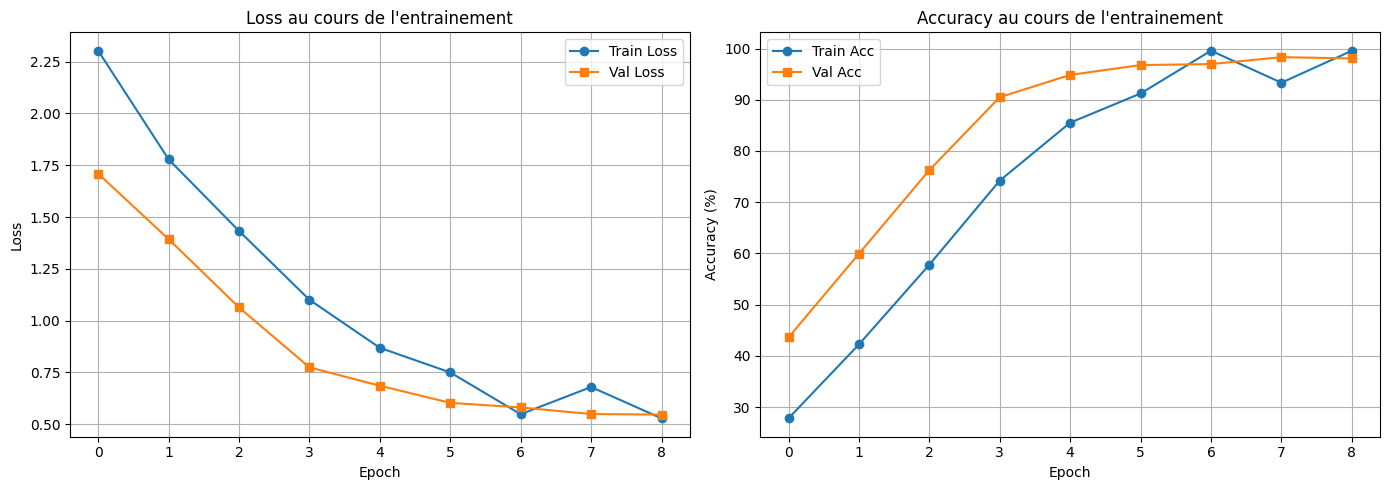

In [19]:
# Charger l'historique depuis le checkpoint
checkpoint = torch.load('./models/last_checkpoint.pth', map_location=device, weights_only=False)
history = checkpoint['history']

# Maintenant tu peux plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss au cours de l\'entrainement')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy au cours de l\'entrainement')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

-----------------------------Evaluation sur le test set

In [17]:
# Charger le meilleur modele (CHEMIN CORRECT)
checkpoint = torch.load('./models/best_model.pth', map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print("✓ Meilleur modele charge pour evaluation")

# Evaluer sur le test set
from sklearn.metrics import accuracy_score, classification_report
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Test Evaluation'):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calcul des metriques
test_acc = accuracy_score(all_labels, all_preds)
print(f"\n✓ Test Accuracy: {test_acc*100:.2f}%")

# Rapport de classification detaille
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

✓ Meilleur modele charge pour evaluation


Test Evaluation: 100%|███████████████████████████████████████████████████████████████| 625/625 [04:32<00:00,  2.29it/s]


✓ Test Accuracy: 98.20%

Classification Report:
                             precision    recall  f1-score   support

          Atopic Dermatitis     0.9844    0.9922    0.9883      1147
              Dermatophytie     0.9831    0.9327    0.9572       995
              Eczema Photos     0.9464    0.9643    0.9552      1007
                       Gale     0.9822    0.9991    0.9906      1158
                     Heathy     1.0000    1.0000    1.0000      1164
                   Impétigo     0.9891    0.9983    0.9937      1184
Maladie cutanée auto-immune     0.9684    0.9426    0.9553       975
            Urticaria Hives     0.9983    1.0000    0.9992      1199
             drug reactions     0.9788    0.9923    0.9855      1163

                   accuracy                         0.9820      9992
                  macro avg     0.9812    0.9801    0.9805      9992
               weighted avg     0.9820    0.9820    0.9819      9992



Matrice de confusion

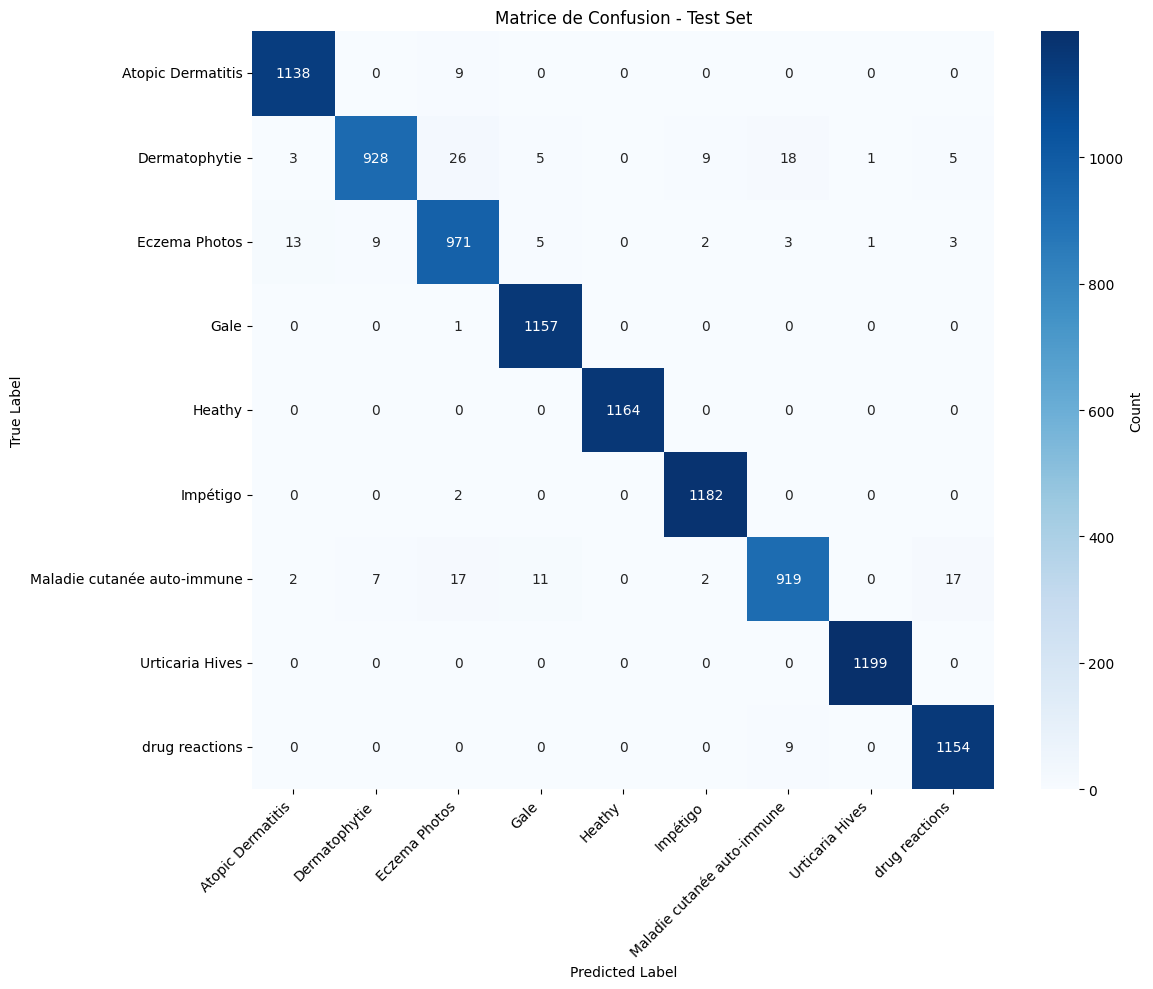

Matrice de confusion sauvegardee dans 'confusion_matrix.png'


In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Vérification que les listes existent (ne change rien d'autre dans ton pipeline)
if 'all_labels' not in globals() or 'all_preds' not in globals():
    raise NameError("all_labels et/ou all_preds ne sont pas définis. Exécutez d'abord la cellule d'évaluation qui remplit ces variables.")

# Calculer la matrice de confusion
cm = confusion_matrix(all_labels, all_preds)

# Visualiser la matrice de confusion
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matrice de Confusion - Test Set')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Matrice de confusion sauvegardee dans 'confusion_matrix.png'")


TEST DU MODELE :

In [ ]:
import torch
from PIL import Image
from torchvision import transforms, models
import matplotlib.pyplot as plt
import torch.nn as nn
import os

# ======================================================
# 1) CONFIGURATION DU DEVICE
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ======================================================
# 2) CHARGER LE CHECKPOINT
# ======================================================
best_model_path = "models/best_model.pth"
checkpoint = torch.load(best_model_path, map_location=device)

# ======================================================
# 3) RECONSTRUIRE LE MODELE AVEC LES MEMES POIDS INITIAUX
# ======================================================
# ⚠️ Utiliser weights=EfficientNet_B4_Weights.DEFAULT si tu veux le même initialisation que le checkpoint
# mais ici on va juste créer le modèle sans pré-entrainement car le checkpoint contient déjà tout
model = models.efficientnet_b4(weights=None)

# ======================================================
# 4) CONFIGURER LA DERNIÈRE COUCHE SELON LES CLASSES DU CHECKPOINT
# ======================================================
class_names = checkpoint["class_names"]
num_classes = len(class_names)

# Remplacer la dernière couche
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# ======================================================
# 5) CHARGER LES POIDS DU CHECKPOINT
# ======================================================
# ⚠️ strict=False permet d'ignorer les différences de clés (utile si ton checkpoint a été enregistré différemment)
model.load_state_dict(checkpoint["model_state_dict"], strict=False)
model.to(device)
model.eval()

print("✅ Modèle EfficientNet reconstruit et chargé avec succès.")
print("Classes :", class_names)

# ======================================================
# 6) TRANSFORMATIONS DES IMAGES
# ======================================================
IMG_SIZE = 380
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ======================================================
# 7) CHARGER UNE IMAGE
# ======================================================
# image_path = "C:/Users/user/Pictures/Screenshots/test.png"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# ======================================================
# 8) PREDICTION
# ======================================================
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)
    predicted_class = class_names[predicted.item()]

print(f"\n🔍 Prédiction : {predicted_class}")

# ======================================================
# 9) AFFICHAGE DE L’IMAGE ET DE LA PREDICTION
# ======================================================
plt.imshow(image)
plt.title(f"Prediction : {predicted_class}")
plt.axis("off")
plt.show()
